In [4]:
%load_ext autoreload
%autoreload 2
from nbutils import chdir_to_root
chdir_to_root()
%pwd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/home/tornikeo/Documents/work/scalexa/pangeaai/optimize-cosine'

In [5]:
from cudams.utils import argbatch, mkdir
from cudams.data import get_ref_spectra_from_df
from cudams.kernel import compile
from cudams.utils import name2idx
from cudams.cosine import similarity
import math
from pathlib import Path
import pandas as pd
from tqdm import tqdm
from cudams.data import spectra_peaks_to_tensor
from cudams.processor import Config
from numba import cuda
from itertools import product
from time import perf_counter
from multiprocessing.pool import ThreadPool
from multiprocessing import shared_memory
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib

assert cuda.is_available()

In [6]:
## Define constants
tolerance: float = 0.1
shift: float = 0
mz_power: float = 0
int_power: float = 1

## How many pairs per batch. Has to be a power of 2.
# Hardware specific - An RTX2070 works best at around 1024 * 2
# But Colab T4 GPU might work best at 1024 * 4
BATCH_SIZE = 512

# MAX NUMBER OF PEAKS 
MAX_N_PEAKS = 1024

# MATCH_LIMIT specifies max how many mz-mz pairs we could consider for each RQ pair, before we sort and filter. 
# E.g. a value of 256 usually causes around ~0.003% of RQ pairs to "overflow".
# The overflown RQ scores will be strictly less than or equal to perfectly accurate score.
# The mean absolute difference at 256, for all overflown pairs is on the order of ~1e-3
# Small values of MATCH_LIMIT (e.g. 128, 64,) cause a dramatic speedup in the processing speed.
MATCH_LIMIT = 1024

## GPU-specific constants
THREADS_PER_BLOCK = (32, 32)
BLOCKS_PER_GRID_X = math.ceil(BATCH_SIZE / THREADS_PER_BLOCK[0])
BLOCKS_PER_GRID_Y = math.ceil(BATCH_SIZE / THREADS_PER_BLOCK[1])
BLOCKS_PER_GRID = (BLOCKS_PER_GRID_X, BLOCKS_PER_GRID_Y)

# Since Greedy cosine is an unstable algorithm, because approximate mz-mz values do not
# result in approximately the same scores and number of matches.
# So we need to use fp64 to minimize the deviation as much as possible.
# Using float32 causes a significant speedup in the processing speed.
dtype = 'float64'

# Data path
reference_csv_file = Path("data/input/test_set_cosine.csv")
query_csv_file = Path("data/input/test_set_cosine.csv")

# For keeping track of experiments

CONFIG = Config(
    tolerance = tolerance,
    shift = shift,
    mz_power = mz_power,
    int_power = int_power,
    dtype = dtype,
    reference_csv_file = reference_csv_file,
    query_csv_file = query_csv_file,
    BATCH_SIZE = BATCH_SIZE,
    MATCH_LIMIT = MATCH_LIMIT,
)

In [7]:
from cudams.processor import CudaCosineGreedy, CpuCosineGreedy
from collections import defaultdict
from matchms import calculate_scores
from matchms.similarity import CosineGreedy
from tqdm import tqdm
from matchms.filtering import normalize_intensities, select_by_mz, select_by_relative_intensity, reduce_to_number_of_peaks, \
    require_minimum_number_of_peaks
from cudams.utils import mute_stdout

acum = []
def it(MAX_N_PEAKS):
    # MATCH_LIMIT = int(MAX_N_PEAKS) # To avoid overflows

    def process_spectrum(spectrum: np.ndarray) -> np.ndarray:
        # spectrum = select_by_mz(spectrum, mz_from=10.0, mz_to=1000.0)
        # spectrum = normalize_intensities(spectrum)
        # spectrum = select_by_relative_intensity(spectrum, intensity_from=0.001)
        # spectrum = reduce_to_number_of_peaks(spectrum, n_max=1000)
        spectrum = reduce_to_number_of_peaks(spectrum, n_max=MAX_N_PEAKS)
        # spectrum = require_minimum_number_of_peaks(spectrum, n_required=5)
        return spectrum

    ref_spectra_df_path = Path(reference_csv_file)
    ref_spectra_df = pd.read_csv(ref_spectra_df_path)
    references = get_ref_spectra_from_df(ref_spectra_df, 
                                        spectrum_processor=process_spectrum,
                                        limit=BATCH_SIZE,)

    query_spectra_df_path = Path(query_csv_file)
    query_spectra_df = pd.read_csv(query_spectra_df_path)
    queries = get_ref_spectra_from_df(query_spectra_df, 
                                    spectrum_processor=process_spectrum,
                                    limit=BATCH_SIZE,)

    print(f"We have {len(references)} references and {len(queries)} queries")

    similarity_measure = CosineGreedy(tolerance= 0.1, 
                                    mz_power= 0.0, 
                                    intensity_power = 1.0)
    C_orig = calculate_scores(references, queries, similarity_measure, is_symmetric=True)
    Cy = C_orig.to_array()
    Cy, Cm = Cy['CosineGreedy_score'], Cy['CosineGreedy_matches']
    Cy = np.stack([Cy,Cm],axis=-1)

    refs = list([r.peaks.to_numpy for r in references])
    ques = list([q.peaks.to_numpy for q in queries])

    rlims = argbatch(refs, BATCH_SIZE)
    qlims = argbatch(ques, BATCH_SIZE)
    R = len(references)
    Q = len(queries)

    batches_rq = list(product(rlims, qlims))

    for (rstart, rend), (qstart, qend) in tqdm(batches_rq, total=len(batches_rq)):
        rspec = refs[rstart:rend]
        qspec = ques[qstart:qend]
        out_true = np.full((BATCH_SIZE, BATCH_SIZE, 2), fill_value=0, dtype='float32')
        for (i, spec1), (j, spec2) in product(enumerate(rspec), enumerate(qspec)):
                score = similarity(
                    spec1,
                    spec2,
                    tolerance=tolerance,
                    shift=shift,
                    mz_power=mz_power,
                    int_power=int_power,
                )
                if score is not None:
                    out_true[i,j,0] = score[0]
                    out_true[i,j,1] = score[1]
        
    C = np.empty((BATCH_SIZE,BATCH_SIZE,2), dtype='float32')
    C[:] = out_true[:]
    
    cosine = CudaCosineGreedy(
                tolerance=.1,
                mz_power=0,
                intensity_power=1, 
                shift=0,
                batch_size=BATCH_SIZE,
                match_limit=MATCH_LIMIT,
            )
    cosine.compile()
    G, Ov = cosine.matrix(
        references=references, 
        queries=queries, 
        array_type="numpy"
    )
    R,Q,_ = Cy.shape
    return MAX_N_PEAKS,C[:R,:Q],G[:R,:Q],Cy[:R,:Q],Ov[:R,:Q]

from joblib import Parallel, delayed

acum = Parallel(n_jobs=6)(
    delayed(
       it 
    )(MAX_N_PEAKS)
    
    for MAX_N_PEAKS in tqdm(np.linspace(128, 8192 // 2, 18, dtype='int32'))
)

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

We have 512 references and 512 queries
We have 512 references and 512 queries
We have 512 references and 512 queries
We have 512 references and 512 queries


100%|██████████| 512/512 [00:00<00:00, 1058.67it/s]


We have 512 references and 512 queries
We have 512 references and 512 queries


100%|██████████| 1/1 [00:04<00:00,  4.45s/it]
Batch all references: 1it [00:00, 76.91it/s]
Batch all queries: 1it [00:00, 77.10it/s]
100%|██████████| 512/512 [00:00<00:00, 938.64it/s] 


We have 512 references and 512 queries


100%|██████████| 1/1 [00:06<00:00,  6.37s/it]
Batch all references: 1it [00:00, 72.28it/s]
Batch all queries: 1it [00:00, 70.78it/s]
100%|██████████| 1/1 [00:07<00:00,  7.04s/it]
Batch all references: 1it [00:00, 60.15it/s]
Batch all queries: 1it [00:00, 65.79it/s]
100%|██████████| 1/1 [00:07<00:00,  7.01s/it]
Batch all references: 1it [00:00, 56.60it/s]
Batch all queries: 1it [00:00, 62.43it/s]
100%|██████████| 1/1 [00:07<00:00,  7.35s/it]
Batch all references: 1it [00:00, 57.09it/s]
Batch all queries: 1it [00:00, 51.63it/s]
100%|██████████| 1/1 [00:07<00:00,  7.40s/it]
Batch all references: 1it [00:00, 49.33it/s]
Batch all queries: 1it [00:00, 50.34it/s]07.51it/s]
100%|██████████| 512/512 [00:00<00:00, 1343.56it/s]


We have 512 references and 512 queries


100%|██████████| 512/512 [00:00<00:00, 745.38it/s]


We have 512 references and 512 queries


100%|██████████| 512/512 [00:00<00:00, 786.80it/s]


We have 512 references and 512 queries


100%|██████████| 512/512 [00:00<00:00, 818.21it/s] 


We have 512 references and 512 queries
We have 512 references and 512 queries


100%|██████████| 1/1 [00:06<00:00,  6.98s/it]
Batch all references: 1it [00:00, 26.88it/s]
Batch all queries: 1it [00:00, 22.78it/s]
100%|██████████| 1/1 [00:05<00:00,  5.12s/it]
Batch all references: 1it [00:00, 39.78it/s]
Batch all queries: 1it [00:00, 42.61it/s]
100%|██████████| 1/1 [00:05<00:00,  5.29s/it]
Batch all references: 1it [00:00, 45.65it/s]
Batch all queries: 1it [00:00, 44.44it/s]
100%|██████████| 512/512 [00:00<00:00, 1109.05it/s]


We have 512 references and 512 queries


100%|██████████| 1/1 [00:05<00:00,  5.12s/it]
Batch all references: 1it [00:00, 23.92it/s]59it/s]
Batch all queries: 1it [00:00, 25.50it/s]
 86%|████████▌ | 441/512 [00:00<00:00, 1040.29it/s]

We have 512 references and 512 queries


100%|██████████| 1/1 [00:05<00:00,  5.29s/it]
Batch all references: 1it [00:00, 42.60it/s]
Batch all queries: 1it [00:00, 42.47it/s]
100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


We have 512 references and 512 queries


100%|██████████| 512/512 [00:00<00:00, 1020.80it/s]


We have 512 references and 512 queries


100%|██████████| 512/512 [00:00<00:00, 980.68it/s] 


We have 512 references and 512 queries


100%|██████████| 1/1 [00:05<00:00,  5.18s/it]
Batch all references: 1it [00:00, 27.35it/s]
Batch all queries: 1it [00:00, 31.30it/s]
100%|██████████| 512/512 [00:00<00:00, 858.69it/s] 


We have 512 references and 512 queries


100%|██████████| 1/1 [00:04<00:00,  4.88s/it]
Batch all references: 1it [00:00, 39.57it/s]
Batch all references: 1it [00:00, 37.32it/s]
Batch all queries: 1it [00:00, 40.98it/s]
Batch all queries: 1it [00:00, 40.12it/s]
100%|██████████| 1/1 [00:04<00:00,  4.69s/it]
Batch all references: 1it [00:00, 38.94it/s]
Batch all queries: 1it [00:00, 43.46it/s]
100%|██████████| 1/1 [00:04<00:00,  4.53s/it]
Batch all references: 1it [00:00, 46.95it/s]
Batch all queries: 1it [00:00, 45.56it/s]
100%|██████████| 1/1 [00:04<00:00,  4.77s/it]
Batch all references: 1it [00:00, 51.61it/s]
Batch all queries: 1it [00:00, 52.62it/s]
100%|██████████| 1/1 [00:03<00:00,  3.93s/it]
Batch all references: 1it [00:00, 47.41it/s]
Batch all queries: 1it [00:00, 51.81it/s]
100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


In [8]:
x = []
y = []
R, Q = BATCH_SIZE, BATCH_SIZE
for MAX_N_PEAKS, C,G,Cy,Ov in acum:
    y_row = []
    # print(MAX_N_PEAKS)
    
    C_match = np.isclose(C[:R,:Q], G[:R,:Q])
    corr = C_match.mean()
    # print("Overflows", Ov[:R,:Q].mean())
    # print("CPU opt vs GPU:", corr)
    y_row.append(corr)

    C_match = np.isclose(Cy[:R,:Q], G[:R,:Q])
    corr = C_match.mean()
    # print("CPU orig vs GPU", corr)
    y_row.append(corr)

    C_match = np.isclose(Cy[:R,:Q], C[:R,:Q])
    corr = C_match.mean()
    # print("CPU orig vs CPU opt", corr)
    y_row.append(corr)
    
    y_row.append(1-Ov.mean())
    
    y.append(y_row)
    x.append(MAX_N_PEAKS)

Text(0.5, 0, 'reduce_to_number_of_peaks(n_max)')

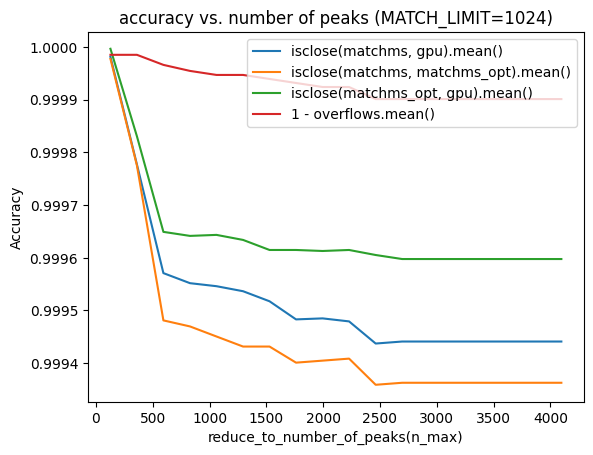

In [9]:
plt.plot(x,y)
plt.title("accuracy vs. number of peaks (MATCH_LIMIT=1024)")
plt.legend(['isclose(matchms, gpu).mean()',
            'isclose(matchms, matchms_opt).mean()',
            'isclose(matchms_opt, gpu).mean()',
            "1 - overflows.mean()"])
plt.ylabel("Accuracy")
plt.xlabel("reduce_to_number_of_peaks(n_max)")

Text(0.5, 0, 'reduce_to_number_of_peaks(n_max)')

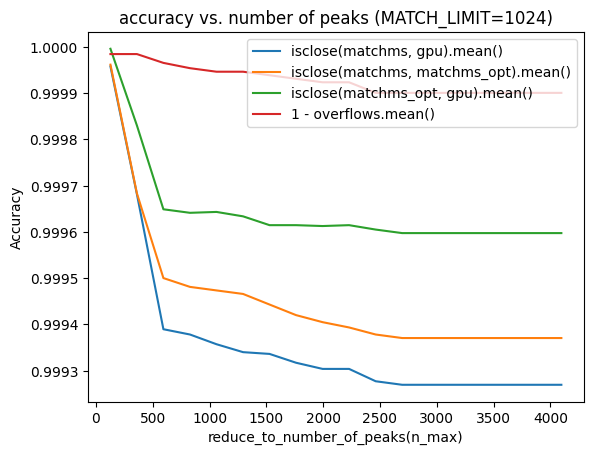

In [6]:
plt.plot(x,y)
plt.title("accuracy vs. number of peaks (MATCH_LIMIT=1024)")
plt.legend(['isclose(matchms, gpu).mean()',
            'isclose(matchms, matchms_opt).mean()',
            'isclose(matchms_opt, gpu).mean()',
            "1 - overflows.mean()"])
plt.ylabel("Accuracy")
plt.xlabel("reduce_to_number_of_peaks(n_max)")